### UNET Model Creation

In [ ]:

import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# Paths
image_folder = "../data/HAM10000_images"
masks_folder = "../data/HAM10000_seg_masks"
csv_file_path = "../data/HAM10000_metadata.csv"

# Configuration
image_size = 224
num_channels = 3
batch_size = 32
epochs = 50

# Preprocessing Functions
def hair_removal(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

def preprocess_image(image_id):
    image = cv2.imread(os.path.join(image_folder, f"{image_id}.jpg"))
    image = cv2.resize(hair_removal(image), (image_size, image_size))
    return image / 255.0  # Normalize to [0, 1]

def preprocess_mask(mask_id):
    mask = cv2.imread(os.path.join(masks_folder, f"{mask_id}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (image_size, image_size))
    return np.expand_dims(mask / 255.0, axis=-1)  # Normalize to [0, 1]

# Data Generator
class DataGenerator(Sequence):
    def __init__(self, image_ids, batch_size):
        self.image_ids = image_ids
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = [], []
        for image_id in batch_ids:
            images.append(preprocess_image(image_id))
            masks.append(preprocess_mask(image_id))
        return np.array(images), np.array(masks)

# Splitting Data
df = pd.read_csv(csv_file_path)
train_ids, val_ids = train_test_split(df['image_id'].values, test_size=0.2, random_state=42)

train_gen = DataGenerator(train_ids, batch_size=batch_size)
val_gen = DataGenerator(val_ids, batch_size=batch_size)

# Model Definition (U-Net)
def build_unet(input_shape=(image_size, image_size, num_channels)):
    inputs = Input(input_shape)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    b1 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    b1 = Conv2D(512, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = UpSampling2D((2, 2))(b1)
    u1 = Concatenate()([u1, c3])
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Concatenate()([u2, c2])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u3 = UpSampling2D((2, 2))(c5)
    u3 = Concatenate()([u3, c1])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)

    return Model(inputs, outputs)

# Compile the Model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the Model
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# Save the Model
model.save("HAM10000_segmentation_model.h5")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_32[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_34[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 28, 28,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_8[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_36[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 56, 56,    │          0 │ conv2d_37[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 56, 56,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 768)              │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │  1,769,728 │ concatenate_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_38[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 112, 112,  │          0 │ conv2d_39[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/home/suresh/ai_in_hc/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 927s 4s/step - accuracy: 0.7929 - loss: 0.5177 - val_accuracy: 0.8511 - val_loss: 0.3683
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.9033 - loss: 0.2502 - val_accuracy: 0.9322 - val_loss: 0.1708
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 920s 4s/step - accuracy: 0.9270 - loss: 0.1856 - val_accuracy: 0.9360 - val_loss: 0.1603
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 922s 4s/step - accuracy: 0.9321 - loss: 0.1712 - val_accuracy: 0.9387 - val_loss: 0.1508
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 920s 4s/step - accuracy: 0.9375 - loss: 0.1556 - val_accuracy: 0.9378 - val_loss: 0.1524
Epoch 6/50
 57/251 ━━━━━━━━━━━━━━━━━━━━ 10:33 3s/step - accuracy: 0.9384 - loss: 0.1529

### Testing the UNET Model with 2 sample images

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


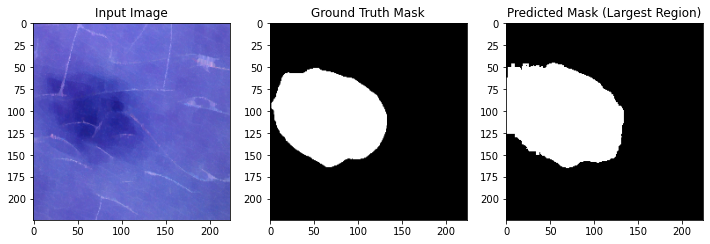

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


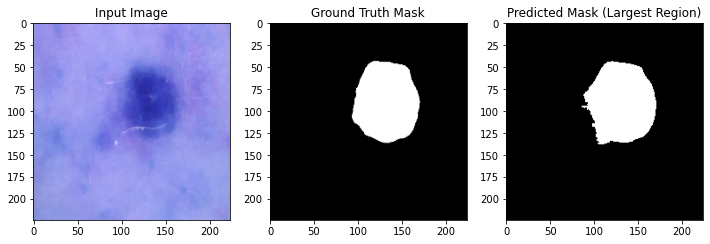

In [8]:
# Imports
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Paths and Constants
model_path = "../HAM10000_segmentation_model.h5"
image_folder = "../data/HAM10000_images"
masks_folder = "../data/HAM10000_seg_masks"
image_size = 224

# Load Trained Model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

# Preprocessing Functions
def hair_removal(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

def preprocess_image(image_id):
    image = cv2.imread(os.path.join(image_folder, f"{image_id}.jpg"))
    image = cv2.resize(hair_removal(image), (image_size, image_size))
    return image / 255.0  # Normalize to [0, 1]

def preprocess_mask(mask_id):
    mask = cv2.imread(os.path.join(masks_folder, f"{mask_id}_segmentation.png"), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (image_size, image_size))
    return np.expand_dims(mask / 255.0, axis=-1)  # Binary mask scaled to [0, 1]

# Function to Retain Only the Largest Contiguous Region
def get_largest_contiguous_region(mask, threshold=0.5):
    """
    Post-processes the predicted mask to retain only the largest contiguous region.
    
    Args:
        mask (numpy.ndarray): The predicted mask from the model (shape: H x W).
        threshold (float): Threshold to binarize the mask.

    Returns:
        numpy.ndarray: Processed mask with only the largest contiguous region.
    """
    # Binarize the mask
    binary_mask = (mask > threshold).astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    # Identify the largest component (exclude background, which is label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Offset by 1 for the background
    largest_region = (labels == largest_label).astype(np.uint8)

    return largest_region

# Test Function
def test_model(image_ids):
    for image_id in image_ids:
        # Load and preprocess image and mask
        image = preprocess_image(image_id)
        mask = preprocess_mask(image_id)

        # Expand dimensions to match model input shape
        input_image = np.expand_dims(image, axis=0)

        # Make prediction
        predicted_mask = model.predict(input_image)[0, :, :, 0]  # Remove batch and channel dimensions

        # Post-process the mask to retain only the largest contiguous region
        largest_region_mask = get_largest_contiguous_region(predicted_mask)

        # Display Results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask.squeeze(), cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask (Largest Region)")
        plt.imshow(largest_region_mask, cmap="gray")

        plt.show()

# Example Test Case
# test_image_ids = ["ISIC_0026795", "ISIC_0032242"]  # Replace with your test image IDs
# test_image_ids = ["ISIC_0025668", "ISIC_0032241"]  # Replace with your test image IDs
test_image_ids = ["ISIC_0025678", "ISIC_0032241"]  # Replace with your test image IDs
test_model(test_image_ids)


### Calculating the Accuracy & IoU Score for the above 2 sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


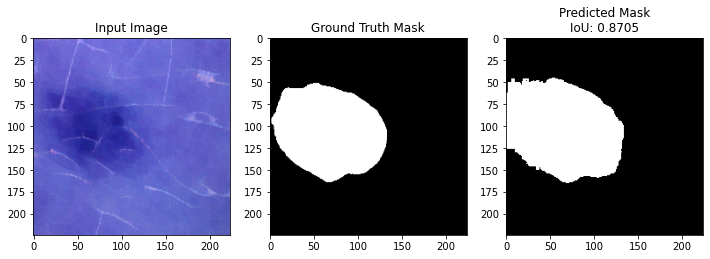

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


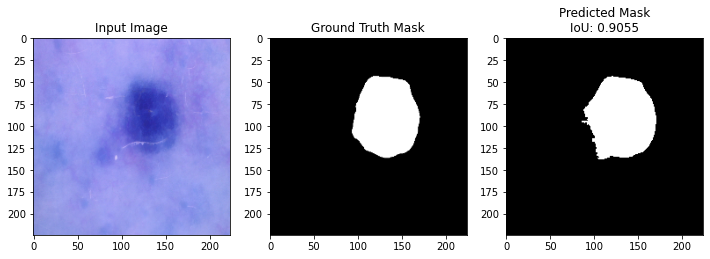

Mean IoU for test images: 0.8880


In [9]:
# Function to Calculate IoU
def calculate_iou(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) score.

    Args:
        y_true (numpy.ndarray): Ground truth binary mask.
        y_pred (numpy.ndarray): Predicted binary mask.

    Returns:
        float: IoU score.
    """
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 0.0

# Test Function with IoU Calculation
def test_model_with_iou(image_ids):
    iou_scores = []
    for image_id in image_ids:
        # Load and preprocess image and mask
        image = preprocess_image(image_id)
        mask = preprocess_mask(image_id).squeeze()  # Remove extra dimension

        # Expand dimensions to match model input shape
        input_image = np.expand_dims(image, axis=0)

        # Make prediction
        predicted_mask = model.predict(input_image)[0, :, :, 0]  # Remove batch and channel dimensions

        # Post-process the mask to retain only the largest contiguous region
        largest_region_mask = get_largest_contiguous_region(predicted_mask)

        # Calculate IoU
        iou_score = calculate_iou(mask > 0.5, largest_region_mask > 0.5)
        iou_scores.append(iou_score)

        # Display Results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask, cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Mask\nIoU: {iou_score:.4f}")
        plt.imshow(largest_region_mask, cmap="gray")

        plt.show()

    # Print Overall Mean IoU
    mean_iou = np.mean(iou_scores)
    print(f"Mean IoU for test images: {mean_iou:.4f}")

# Example Test Case with IoU Calculation
test_image_ids = ["ISIC_0025678", "ISIC_0032241"]  # Replace with your test image IDs
test_model_with_iou(test_image_ids)


### Testing the UNET Model with 2000 testing images

In [11]:
# Function to Calculate IoU Between Two Masks
def calculate_iou(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) score.
    Args:
        y_true (numpy.ndarray): Ground truth binary mask.
        y_pred (numpy.ndarray): Predicted binary mask.
    Returns:
        float: IoU score.
    """
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

# Function to Evaluate IoU on Test Dataset
def evaluate_iou_on_test_set(test_image_ids):
    iou_scores = []
    for image_id in tqdm(test_image_ids, desc="Calculating IoU for Test Dataset"):
        # Load and preprocess ground truth mask
        mask = preprocess_mask(image_id).squeeze()  # Remove channel dimension

        # Preprocess input image
        image = preprocess_image(image_id)
        input_image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Make prediction
        predicted_mask = model.predict(input_image)[0, :, :, 0]  # Remove batch and channel dimensions

        # Post-process the mask to retain only the largest contiguous region
        largest_region_mask = get_largest_contiguous_region(predicted_mask)

        # Calculate IoU
        iou_score = calculate_iou(mask > 0.5, largest_region_mask > 0.5)
        iou_scores.append(iou_score)

    # Calculate Mean IoU
    mean_iou = np.mean(iou_scores)
    print(f"Mean IoU for Test Dataset: {mean_iou:.4f}")
    return mean_iou, iou_scores

# Example Usage

from sklearn.metrics import jaccard_score
from tqdm import tqdm
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import pandas as pd

# Paths
image_folder = "../data/HAM10000_images"
masks_folder = "../data/HAM10000_seg_masks"
csv_file_path = "../data/HAM10000_metadata.csv"

# Configuration
image_size = 224
num_channels = 3
batch_size = 32
epochs = 50


# Splitting Data
df = pd.read_csv(csv_file_path)
train_ids, test_ids = train_test_split(df['image_id'].values, test_size=0.2, random_state=42)
# Evaluate IoU on Test Dataset
mean_iou, iou_scores = evaluate_iou_on_test_set(test_ids)


Calculating IoU for Test Dataset:   0%|          | 0/2003 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   0%|          | 1/2003 [00:00<07:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   0%|          | 2/2003 [00:00<06:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   0%|          | 3/2003 [00:00<05:57,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   0%|          | 4/2003 [00:00<05:49,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   0%|          | 5/2003 [00:00<05:38,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   0%|          | 6/2003 [00:01<05:43,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   0%|          | 7/2003 [00:01<05:25,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   0%|          | 8/2003 [00:01<05:11,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   0%|          | 9/2003 [00:01<05:17,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   0%|          | 10/2003 [00:01<05:15,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 11/2003 [00:01<05:03,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 12/2003 [00:01<04:52,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Calculating IoU for Test Dataset:   1%|          | 13/2003 [00:02<05:09,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|          | 14/2003 [00:02<05:02,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|          | 15/2003 [00:02<05:09,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 16/2003 [00:02<04:59,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 17/2003 [00:02<05:06,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|          | 18/2003 [00:02<05:06,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|          | 19/2003 [00:03<05:05,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   1%|          | 20/2003 [00:03<04:58,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|          | 21/2003 [00:03<04:51,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 22/2003 [00:03<04:44,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 23/2003 [00:03<04:54,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 24/2003 [00:03<04:51,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|          | 25/2003 [00:03<05:01,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   1%|▏         | 26/2003 [00:04<04:55,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Calculating IoU for Test Dataset:   1%|▏         | 27/2003 [00:04<05:12,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   1%|▏         | 28/2003 [00:04<05:05,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   1%|▏         | 29/2003 [00:04<05:14,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   1%|▏         | 30/2003 [00:04<05:00,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Calculating IoU for Test Dataset:   2%|▏         | 31/2003 [00:04<05:57,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 32/2003 [00:05<05:53,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 33/2003 [00:05<05:28,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 34/2003 [00:05<05:26,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 35/2003 [00:05<05:30,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 36/2003 [00:05<05:12,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 37/2003 [00:05<04:59,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 38/2003 [00:05<04:51,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 39/2003 [00:06<04:44,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 40/2003 [00:06<04:45,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 41/2003 [00:06<04:46,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 42/2003 [00:06<04:45,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   2%|▏         | 43/2003 [00:06<04:58,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 44/2003 [00:06<04:58,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   2%|▏         | 45/2003 [00:07<04:55,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 46/2003 [00:07<05:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   2%|▏         | 47/2003 [00:07<04:59,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   2%|▏         | 48/2003 [00:07<04:51,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   2%|▏         | 49/2003 [00:07<04:42,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   2%|▏         | 50/2003 [00:07<04:54,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 51/2003 [00:07<05:02,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 52/2003 [00:08<05:01,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   3%|▎         | 53/2003 [00:08<05:22,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   3%|▎         | 54/2003 [00:08<05:15,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   3%|▎         | 55/2003 [00:08<05:03,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   3%|▎         | 56/2003 [00:08<05:28,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   3%|▎         | 57/2003 [00:08<05:33,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:   3%|▎         | 58/2003 [00:09<05:32,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   3%|▎         | 59/2003 [00:09<05:19,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   3%|▎         | 60/2003 [00:09<05:19,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   3%|▎         | 61/2003 [00:09<05:05,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 62/2003 [00:09<05:06,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   3%|▎         | 63/2003 [00:09<05:05,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 64/2003 [00:10<05:03,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 65/2003 [00:10<05:05,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   3%|▎         | 66/2003 [00:10<05:12,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 67/2003 [00:10<05:04,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   3%|▎         | 68/2003 [00:10<04:53,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   3%|▎         | 69/2003 [00:10<04:52,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   3%|▎         | 70/2003 [00:10<04:52,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▎         | 71/2003 [00:11<04:48,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   4%|▎         | 72/2003 [00:11<04:42,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▎         | 73/2003 [00:11<04:42,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   4%|▎         | 74/2003 [00:11<04:39,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▎         | 75/2003 [00:11<04:52,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 76/2003 [00:11<04:50,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 77/2003 [00:12<04:52,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Calculating IoU for Test Dataset:   4%|▍         | 78/2003 [00:12<04:59,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   4%|▍         | 79/2003 [00:12<05:01,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   4%|▍         | 80/2003 [00:12<04:58,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 81/2003 [00:12<04:52,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 82/2003 [00:12<05:08,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   4%|▍         | 83/2003 [00:12<04:55,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 84/2003 [00:13<04:47,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   4%|▍         | 85/2003 [00:13<04:58,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 86/2003 [00:13<04:53,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   4%|▍         | 87/2003 [00:13<04:50,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 88/2003 [00:13<04:54,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   4%|▍         | 89/2003 [00:13<04:48,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   4%|▍         | 90/2003 [00:14<04:54,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▍         | 91/2003 [00:14<04:45,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:   5%|▍         | 92/2003 [00:14<04:40,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Calculating IoU for Test Dataset:   5%|▍         | 93/2003 [00:14<04:48,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   5%|▍         | 94/2003 [00:14<05:16,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▍         | 95/2003 [00:14<05:06,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   5%|▍         | 96/2003 [00:14<04:57,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▍         | 97/2003 [00:15<04:48,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▍         | 98/2003 [00:15<04:43,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▍         | 99/2003 [00:15<04:37,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   5%|▍         | 100/2003 [00:15<04:56,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   5%|▌         | 101/2003 [00:15<04:55,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   5%|▌         | 102/2003 [00:15<04:47,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Calculating IoU for Test Dataset:   5%|▌         | 103/2003 [00:16<04:45,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▌         | 104/2003 [00:16<05:18,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▌         | 105/2003 [00:16<05:24,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▌         | 106/2003 [00:16<05:20,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   5%|▌         | 107/2003 [00:16<05:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▌         | 108/2003 [00:16<04:54,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▌         | 109/2003 [00:16<04:43,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   5%|▌         | 110/2003 [00:17<04:48,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 111/2003 [00:17<04:59,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 112/2003 [00:17<04:58,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 113/2003 [00:17<05:00,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 114/2003 [00:17<04:58,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 115/2003 [00:17<04:47,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 116/2003 [00:18<04:59,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 117/2003 [00:18<04:52,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 118/2003 [00:18<04:49,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   6%|▌         | 119/2003 [00:18<04:51,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 120/2003 [00:18<04:54,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▌         | 121/2003 [00:18<04:42,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 122/2003 [00:19<04:47,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 123/2003 [00:19<04:55,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▌         | 124/2003 [00:19<04:46,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   6%|▌         | 125/2003 [00:19<04:56,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   6%|▋         | 126/2003 [00:19<04:45,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   6%|▋         | 127/2003 [00:19<04:50,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▋         | 128/2003 [00:19<04:45,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   6%|▋         | 129/2003 [00:20<04:42,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   6%|▋         | 130/2003 [00:20<04:39,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 131/2003 [00:20<04:45,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 132/2003 [00:20<04:43,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 133/2003 [00:20<04:44,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 134/2003 [00:20<04:47,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 135/2003 [00:21<04:44,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 136/2003 [00:21<04:39,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 137/2003 [00:21<04:35,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 138/2003 [00:21<04:29,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 139/2003 [00:21<04:29,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   7%|▋         | 140/2003 [00:21<04:29,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 141/2003 [00:21<04:35,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 142/2003 [00:22<04:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   7%|▋         | 143/2003 [00:22<04:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   7%|▋         | 144/2003 [00:22<04:38,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 145/2003 [00:22<04:33,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   7%|▋         | 146/2003 [00:22<04:36,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   7%|▋         | 147/2003 [00:22<04:31,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 148/2003 [00:22<04:43,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   7%|▋         | 149/2003 [00:23<04:43,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   7%|▋         | 150/2003 [00:23<04:55,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 151/2003 [00:23<04:47,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   8%|▊         | 152/2003 [00:23<04:39,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 153/2003 [00:23<04:35,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 154/2003 [00:23<04:33,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:   8%|▊         | 155/2003 [00:24<05:02,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   8%|▊         | 156/2003 [00:24<05:02,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   8%|▊         | 157/2003 [00:24<04:54,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Calculating IoU for Test Dataset:   8%|▊         | 158/2003 [00:24<05:16,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   8%|▊         | 159/2003 [00:24<05:04,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 160/2003 [00:24<05:03,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 161/2003 [00:24<04:48,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 162/2003 [00:25<04:38,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   8%|▊         | 163/2003 [00:25<04:46,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   8%|▊         | 164/2003 [00:25<04:38,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 165/2003 [00:25<04:49,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   8%|▊         | 166/2003 [00:25<04:47,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 167/2003 [00:25<04:40,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   8%|▊         | 168/2003 [00:26<05:02,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   8%|▊         | 169/2003 [00:26<04:59,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   8%|▊         | 170/2003 [00:26<04:50,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▊         | 171/2003 [00:26<04:48,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▊         | 172/2003 [00:26<04:39,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   9%|▊         | 173/2003 [00:26<04:42,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   9%|▊         | 174/2003 [00:27<04:34,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▊         | 175/2003 [00:27<04:28,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 176/2003 [00:27<04:22,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 177/2003 [00:27<04:25,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   9%|▉         | 178/2003 [00:27<04:30,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   9%|▉         | 179/2003 [00:27<04:29,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 180/2003 [00:27<04:42,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 181/2003 [00:28<04:39,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 182/2003 [00:28<04:35,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 183/2003 [00:28<04:33,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 184/2003 [00:28<04:38,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 185/2003 [00:28<04:42,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:   9%|▉         | 186/2003 [00:28<04:36,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   9%|▉         | 187/2003 [00:28<04:36,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:   9%|▉         | 188/2003 [00:29<04:30,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:   9%|▉         | 189/2003 [00:29<04:31,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:   9%|▉         | 190/2003 [00:29<04:32,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  10%|▉         | 191/2003 [00:29<04:34,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 192/2003 [00:29<04:40,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  10%|▉         | 193/2003 [00:29<04:39,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 194/2003 [00:30<04:33,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  10%|▉         | 195/2003 [00:30<04:32,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 196/2003 [00:30<04:29,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  10%|▉         | 197/2003 [00:30<04:43,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 198/2003 [00:30<04:33,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 199/2003 [00:30<04:28,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|▉         | 200/2003 [00:30<04:25,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|█         | 201/2003 [00:31<04:36,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  10%|█         | 202/2003 [00:31<04:39,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  10%|█         | 203/2003 [00:31<04:31,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  10%|█         | 204/2003 [00:31<04:35,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  10%|█         | 205/2003 [00:31<04:32,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|█         | 206/2003 [00:31<04:54,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|█         | 207/2003 [00:32<04:40,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  10%|█         | 208/2003 [00:32<04:43,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  10%|█         | 209/2003 [00:32<04:40,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  10%|█         | 210/2003 [00:32<04:40,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 211/2003 [00:32<04:30,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 212/2003 [00:32<04:28,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 213/2003 [00:32<04:44,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█         | 214/2003 [00:33<04:33,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 215/2003 [00:33<04:24,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 216/2003 [00:33<04:30,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 217/2003 [00:33<04:26,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 218/2003 [00:33<04:19,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█         | 219/2003 [00:33<04:35,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█         | 220/2003 [00:34<04:31,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█         | 221/2003 [00:34<04:22,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 222/2003 [00:34<04:31,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 223/2003 [00:34<04:33,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█         | 224/2003 [00:34<04:29,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  11%|█         | 225/2003 [00:34<04:37,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█▏        | 226/2003 [00:34<04:30,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█▏        | 227/2003 [00:35<04:30,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  11%|█▏        | 228/2003 [00:35<04:28,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  11%|█▏        | 229/2003 [00:35<04:29,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  11%|█▏        | 230/2003 [00:35<04:36,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 231/2003 [00:35<04:37,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 232/2003 [00:35<04:41,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 233/2003 [00:36<04:38,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 234/2003 [00:36<04:27,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 235/2003 [00:36<04:20,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 236/2003 [00:36<04:15,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 237/2003 [00:36<04:25,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 238/2003 [00:36<04:26,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 239/2003 [00:36<04:40,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 240/2003 [00:37<04:28,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 241/2003 [00:37<04:19,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 242/2003 [00:37<04:25,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 243/2003 [00:37<04:26,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 244/2003 [00:37<04:23,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 245/2003 [00:37<04:19,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 246/2003 [00:37<04:10,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 247/2003 [00:38<04:14,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 248/2003 [00:38<04:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 249/2003 [00:38<04:20,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  12%|█▏        | 250/2003 [00:38<04:27,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 251/2003 [00:38<04:29,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 252/2003 [00:38<04:33,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 253/2003 [00:38<04:23,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 254/2003 [00:39<04:27,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 255/2003 [00:39<04:24,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 256/2003 [00:39<04:21,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 257/2003 [00:39<04:23,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 258/2003 [00:39<04:22,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 259/2003 [00:39<04:19,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 260/2003 [00:40<04:15,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 261/2003 [00:40<04:22,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 262/2003 [00:40<04:19,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 263/2003 [00:40<04:17,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 264/2003 [00:40<04:35,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 265/2003 [00:40<04:39,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 266/2003 [00:40<04:30,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 267/2003 [00:41<04:30,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 268/2003 [00:41<04:19,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 269/2003 [00:41<04:17,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  13%|█▎        | 270/2003 [00:41<04:38,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▎        | 271/2003 [00:41<04:50,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▎        | 272/2003 [00:41<04:39,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▎        | 273/2003 [00:42<04:37,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▎        | 274/2003 [00:42<04:39,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▎        | 275/2003 [00:42<04:31,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 276/2003 [00:42<04:29,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 277/2003 [00:42<04:27,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 278/2003 [00:42<04:21,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 279/2003 [00:43<04:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 280/2003 [00:43<04:16,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 281/2003 [00:43<04:24,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 282/2003 [00:43<04:22,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 283/2003 [00:43<04:39,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 284/2003 [00:43<04:37,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 285/2003 [00:43<04:31,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 286/2003 [00:44<04:28,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 287/2003 [00:44<04:29,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 288/2003 [00:44<04:29,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 289/2003 [00:44<04:25,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  14%|█▍        | 290/2003 [00:44<04:22,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 291/2003 [00:44<04:14,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 292/2003 [00:45<04:09,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 293/2003 [00:45<04:14,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 294/2003 [00:45<04:22,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 295/2003 [00:45<04:28,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 296/2003 [00:45<04:18,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 297/2003 [00:45<04:11,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 298/2003 [00:45<04:13,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 299/2003 [00:46<04:06,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▍        | 300/2003 [00:46<03:59,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 301/2003 [00:46<04:24,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 302/2003 [00:46<04:12,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 303/2003 [00:46<04:08,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 304/2003 [00:46<04:09,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 305/2003 [00:46<04:09,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 306/2003 [00:47<04:06,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 307/2003 [00:47<04:10,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 308/2003 [00:47<04:30,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 309/2003 [00:47<04:31,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  15%|█▌        | 310/2003 [00:47<04:35,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 311/2003 [00:47<04:29,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 312/2003 [00:48<04:33,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 313/2003 [00:48<04:49,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 314/2003 [00:48<04:29,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 315/2003 [00:48<04:18,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 316/2003 [00:48<04:29,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 317/2003 [00:48<04:20,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 318/2003 [00:49<04:33,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 319/2003 [00:49<04:49,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 320/2003 [00:49<04:44,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 321/2003 [00:49<04:46,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 322/2003 [00:49<04:33,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 323/2003 [00:49<04:35,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 324/2003 [00:50<04:25,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▌        | 325/2003 [00:50<04:17,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▋        | 326/2003 [00:50<04:15,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▋        | 327/2003 [00:50<04:11,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  16%|█▋        | 328/2003 [00:50<04:20,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  16%|█▋        | 329/2003 [00:50<04:15,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  16%|█▋        | 330/2003 [00:50<04:18,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 331/2003 [00:51<04:16,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 332/2003 [00:51<04:05,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 333/2003 [00:51<04:04,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 334/2003 [00:51<04:17,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 335/2003 [00:51<04:08,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 336/2003 [00:51<04:11,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 337/2003 [00:51<04:05,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 338/2003 [00:52<04:10,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 339/2003 [00:52<04:34,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 340/2003 [00:52<04:29,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 341/2003 [00:52<04:20,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 342/2003 [00:52<04:13,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 343/2003 [00:52<04:10,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 344/2003 [00:53<04:04,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 345/2003 [00:53<04:07,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 346/2003 [00:53<04:20,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 347/2003 [00:53<04:14,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 348/2003 [00:53<04:15,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 349/2003 [00:53<04:13,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  17%|█▋        | 350/2003 [00:53<04:15,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 351/2003 [00:54<04:10,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 352/2003 [00:54<04:15,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 353/2003 [00:54<04:08,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 354/2003 [00:54<04:22,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 355/2003 [00:54<04:20,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 356/2003 [00:54<04:11,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 357/2003 [00:55<04:03,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 358/2003 [00:55<04:02,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 359/2003 [00:55<04:02,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 360/2003 [00:55<04:25,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 361/2003 [00:55<04:12,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 362/2003 [00:55<04:17,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 363/2003 [00:56<04:22,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 364/2003 [00:56<04:17,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 365/2003 [00:56<04:18,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 366/2003 [00:56<04:20,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 367/2003 [00:56<04:22,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 368/2003 [00:56<04:14,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 369/2003 [00:56<04:10,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  18%|█▊        | 370/2003 [00:57<04:10,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  19%|█▊        | 371/2003 [00:57<04:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  19%|█▊        | 372/2003 [00:57<04:09,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  19%|█▊        | 373/2003 [00:57<04:04,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  19%|█▊        | 374/2003 [00:57<03:58,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▊        | 375/2003 [00:57<04:13,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 376/2003 [00:57<04:07,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 377/2003 [00:58<04:02,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 378/2003 [00:58<04:18,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 379/2003 [00:58<04:29,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 380/2003 [00:58<04:23,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 381/2003 [00:58<04:13,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 382/2003 [00:58<04:09,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 383/2003 [00:59<04:22,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 384/2003 [00:59<04:24,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 385/2003 [00:59<04:08,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 386/2003 [00:59<04:32,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 387/2003 [00:59<04:14,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 388/2003 [00:59<04:07,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 389/2003 [01:00<04:18,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  19%|█▉        | 390/2003 [01:00<04:30,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 391/2003 [01:00<04:21,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 392/2003 [01:00<04:16,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 393/2003 [01:00<04:13,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 394/2003 [01:00<04:21,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 395/2003 [01:01<04:10,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 396/2003 [01:01<04:16,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 397/2003 [01:01<04:08,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 398/2003 [01:01<04:00,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 399/2003 [01:01<04:03,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|█▉        | 400/2003 [01:01<04:00,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|██        | 401/2003 [01:01<04:02,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  20%|██        | 402/2003 [01:02<03:57,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  20%|██        | 403/2003 [01:02<04:00,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|██        | 404/2003 [01:02<04:04,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|██        | 405/2003 [01:02<03:56,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|██        | 406/2003 [01:02<04:07,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|██        | 407/2003 [01:02<04:25,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  20%|██        | 408/2003 [01:03<04:22,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|██        | 409/2003 [01:03<04:22,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  20%|██        | 410/2003 [01:03<04:18,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 411/2003 [01:03<04:12,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██        | 412/2003 [01:03<04:06,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 413/2003 [01:03<04:08,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██        | 414/2003 [01:04<04:21,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 415/2003 [01:04<04:10,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██        | 416/2003 [01:04<04:18,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██        | 417/2003 [01:04<04:10,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██        | 418/2003 [01:04<04:03,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██        | 419/2003 [01:04<04:17,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 420/2003 [01:04<04:08,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 421/2003 [01:05<04:14,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██        | 422/2003 [01:05<04:09,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██        | 423/2003 [01:05<04:24,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██        | 424/2003 [01:05<04:09,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██        | 425/2003 [01:05<03:58,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██▏       | 426/2003 [01:05<03:55,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  21%|██▏       | 427/2003 [01:06<03:48,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  21%|██▏       | 428/2003 [01:06<03:43,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Calculating IoU for Test Dataset:  21%|██▏       | 429/2003 [01:06<03:50,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  21%|██▏       | 430/2003 [01:06<04:01,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 431/2003 [01:06<04:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 432/2003 [01:06<04:12,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 433/2003 [01:06<04:05,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 434/2003 [01:07<04:19,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 435/2003 [01:07<04:26,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 436/2003 [01:07<04:14,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 437/2003 [01:07<04:01,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 438/2003 [01:07<04:14,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 439/2003 [01:07<04:13,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 440/2003 [01:08<04:05,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 441/2003 [01:08<04:12,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 442/2003 [01:08<04:10,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 443/2003 [01:08<04:01,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 444/2003 [01:08<04:01,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 445/2003 [01:08<03:58,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 446/2003 [01:09<04:01,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 447/2003 [01:09<03:55,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 448/2003 [01:09<03:59,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 449/2003 [01:09<04:13,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  22%|██▏       | 450/2003 [01:09<04:01,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 451/2003 [01:09<04:10,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 452/2003 [01:09<04:11,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 453/2003 [01:10<04:03,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 454/2003 [01:10<04:07,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 455/2003 [01:10<04:11,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 456/2003 [01:10<04:04,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 457/2003 [01:10<04:00,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 458/2003 [01:10<04:06,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 459/2003 [01:11<03:57,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 460/2003 [01:11<04:07,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 461/2003 [01:11<04:06,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 462/2003 [01:11<04:02,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 463/2003 [01:11<03:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 464/2003 [01:11<04:03,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 465/2003 [01:12<03:54,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 466/2003 [01:12<03:50,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 467/2003 [01:12<03:54,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 468/2003 [01:12<04:10,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 469/2003 [01:12<03:57,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  23%|██▎       | 470/2003 [01:12<04:00,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  24%|██▎       | 471/2003 [01:12<03:50,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▎       | 472/2003 [01:13<03:57,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▎       | 473/2003 [01:13<04:08,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  24%|██▎       | 474/2003 [01:13<04:08,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  24%|██▎       | 475/2003 [01:13<03:58,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 476/2003 [01:13<04:13,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 477/2003 [01:13<04:04,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 478/2003 [01:14<04:11,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 479/2003 [01:14<04:13,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 480/2003 [01:14<04:02,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 481/2003 [01:14<03:59,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 482/2003 [01:14<03:49,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 483/2003 [01:14<04:11,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 484/2003 [01:15<04:23,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 485/2003 [01:15<04:13,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 486/2003 [01:15<04:02,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 487/2003 [01:15<04:07,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 488/2003 [01:15<04:01,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 489/2003 [01:15<04:06,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  24%|██▍       | 490/2003 [01:16<03:57,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 491/2003 [01:16<04:01,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 492/2003 [01:16<04:09,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 493/2003 [01:16<04:24,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 494/2003 [01:16<04:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 495/2003 [01:16<04:08,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 496/2003 [01:17<04:05,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 497/2003 [01:17<03:55,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 498/2003 [01:17<03:58,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 499/2003 [01:17<04:00,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▍       | 500/2003 [01:17<04:04,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 501/2003 [01:17<04:21,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 502/2003 [01:18<04:09,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 503/2003 [01:18<04:11,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 504/2003 [01:18<04:01,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 505/2003 [01:18<03:54,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 506/2003 [01:18<03:45,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 507/2003 [01:18<03:46,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 508/2003 [01:18<03:51,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 509/2003 [01:19<03:48,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  25%|██▌       | 510/2003 [01:19<03:51,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 511/2003 [01:19<03:46,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 512/2003 [01:19<03:41,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 513/2003 [01:19<03:47,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 514/2003 [01:19<03:47,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 515/2003 [01:20<03:51,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 516/2003 [01:20<03:46,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 517/2003 [01:20<03:43,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 518/2003 [01:20<03:38,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 519/2003 [01:20<03:59,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 520/2003 [01:20<03:51,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 521/2003 [01:20<03:43,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 522/2003 [01:21<03:40,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 523/2003 [01:21<03:39,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 524/2003 [01:21<03:43,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  26%|██▌       | 525/2003 [01:21<03:51,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  26%|██▋       | 526/2003 [01:21<03:54,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  26%|██▋       | 527/2003 [01:21<03:45,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  26%|██▋       | 528/2003 [01:21<03:45,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  26%|██▋       | 529/2003 [01:22<03:55,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  26%|██▋       | 530/2003 [01:22<03:52,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 531/2003 [01:22<03:58,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 532/2003 [01:22<03:48,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 533/2003 [01:22<04:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 534/2003 [01:22<04:04,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 535/2003 [01:23<03:55,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 536/2003 [01:23<03:50,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 537/2003 [01:23<03:39,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 538/2003 [01:23<03:39,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 539/2003 [01:23<03:48,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 540/2003 [01:23<03:48,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 541/2003 [01:24<03:46,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 542/2003 [01:24<04:07,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 543/2003 [01:24<03:54,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 544/2003 [01:24<04:06,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 545/2003 [01:24<03:55,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 546/2003 [01:24<03:48,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 547/2003 [01:25<03:54,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 548/2003 [01:25<03:44,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 549/2003 [01:25<03:44,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  27%|██▋       | 550/2003 [01:25<03:59,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 551/2003 [01:25<03:55,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 552/2003 [01:25<03:53,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 553/2003 [01:25<03:54,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 554/2003 [01:26<04:08,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 555/2003 [01:26<04:05,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 556/2003 [01:26<03:53,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 557/2003 [01:26<03:53,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 558/2003 [01:26<03:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 559/2003 [01:26<04:00,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 560/2003 [01:27<03:54,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 561/2003 [01:27<03:47,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 562/2003 [01:27<03:48,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 563/2003 [01:27<03:44,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 564/2003 [01:27<03:51,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 565/2003 [01:27<03:50,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 566/2003 [01:28<03:47,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 567/2003 [01:28<03:37,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 568/2003 [01:28<03:35,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 569/2003 [01:28<03:29,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  28%|██▊       | 570/2003 [01:28<03:28,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▊       | 571/2003 [01:28<03:33,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  29%|██▊       | 572/2003 [01:28<03:26,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  29%|██▊       | 573/2003 [01:29<03:26,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▊       | 574/2003 [01:29<03:29,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  29%|██▊       | 575/2003 [01:29<03:36,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 576/2003 [01:29<03:41,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 577/2003 [01:29<03:35,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 578/2003 [01:29<03:35,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 579/2003 [01:30<03:34,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 580/2003 [01:30<03:39,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 581/2003 [01:30<03:40,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 582/2003 [01:30<03:41,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 583/2003 [01:30<03:35,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 584/2003 [01:30<03:33,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 585/2003 [01:30<03:37,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 586/2003 [01:31<03:36,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 587/2003 [01:31<03:31,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 588/2003 [01:31<03:38,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 589/2003 [01:31<03:45,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  29%|██▉       | 590/2003 [01:31<03:37,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 591/2003 [01:31<03:31,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 592/2003 [01:31<03:26,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 593/2003 [01:32<03:28,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 594/2003 [01:32<03:43,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 595/2003 [01:32<03:43,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 596/2003 [01:32<03:50,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 597/2003 [01:32<03:44,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 598/2003 [01:32<03:48,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 599/2003 [01:33<03:43,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  30%|██▉       | 600/2003 [01:33<03:47,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  30%|███       | 601/2003 [01:33<03:54,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  30%|███       | 602/2003 [01:33<03:47,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|███       | 603/2003 [01:33<03:40,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  30%|███       | 604/2003 [01:33<03:31,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  30%|███       | 605/2003 [01:34<03:35,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|███       | 606/2003 [01:34<03:35,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|███       | 607/2003 [01:34<03:31,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  30%|███       | 608/2003 [01:34<03:34,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  30%|███       | 609/2003 [01:34<03:29,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  30%|███       | 610/2003 [01:34<03:45,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  31%|███       | 611/2003 [01:34<03:34,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███       | 612/2003 [01:35<03:37,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███       | 613/2003 [01:35<03:39,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███       | 614/2003 [01:35<03:30,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███       | 615/2003 [01:35<03:37,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███       | 616/2003 [01:35<03:31,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███       | 617/2003 [01:35<03:29,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███       | 618/2003 [01:36<03:26,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  31%|███       | 619/2003 [01:36<03:26,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  31%|███       | 620/2003 [01:36<03:28,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  31%|███       | 621/2003 [01:36<03:37,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███       | 622/2003 [01:36<03:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███       | 623/2003 [01:36<03:37,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  31%|███       | 624/2003 [01:37<03:38,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███       | 625/2003 [01:37<03:34,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███▏      | 626/2003 [01:37<03:41,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  31%|███▏      | 627/2003 [01:37<03:36,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███▏      | 628/2003 [01:37<03:32,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  31%|███▏      | 629/2003 [01:37<03:43,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  31%|███▏      | 630/2003 [01:37<03:39,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 631/2003 [01:38<03:33,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 632/2003 [01:38<03:40,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 633/2003 [01:38<03:28,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 634/2003 [01:38<03:28,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 635/2003 [01:38<03:23,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 636/2003 [01:38<03:18,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 637/2003 [01:38<03:21,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 638/2003 [01:39<03:20,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 639/2003 [01:39<03:21,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 640/2003 [01:39<03:28,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 641/2003 [01:39<03:27,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 642/2003 [01:39<03:43,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 643/2003 [01:39<03:35,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 644/2003 [01:40<03:29,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 645/2003 [01:40<03:28,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 646/2003 [01:40<03:28,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 647/2003 [01:40<03:31,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 648/2003 [01:40<03:36,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 649/2003 [01:40<03:36,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  32%|███▏      | 650/2003 [01:41<03:40,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 651/2003 [01:41<03:32,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 652/2003 [01:41<03:29,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 653/2003 [01:41<03:32,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 654/2003 [01:41<03:32,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 655/2003 [01:41<03:26,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 656/2003 [01:41<03:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 657/2003 [01:42<03:16,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 658/2003 [01:42<03:33,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 659/2003 [01:42<03:34,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 660/2003 [01:42<03:28,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 661/2003 [01:42<03:23,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 662/2003 [01:42<03:16,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 663/2003 [01:43<03:18,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 664/2003 [01:43<03:20,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 665/2003 [01:43<03:16,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 666/2003 [01:43<03:20,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 667/2003 [01:43<03:16,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 668/2003 [01:43<03:19,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 669/2003 [01:43<03:17,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 670/2003 [01:44<03:17,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  33%|███▎      | 671/2003 [01:44<03:16,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  34%|███▎      | 672/2003 [01:44<03:17,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  34%|███▎      | 673/2003 [01:44<03:37,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  34%|███▎      | 674/2003 [01:44<03:30,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▎      | 675/2003 [01:44<03:34,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▎      | 676/2003 [01:45<03:26,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 677/2003 [01:45<03:23,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 678/2003 [01:45<03:19,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 679/2003 [01:45<03:25,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 680/2003 [01:45<03:28,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 681/2003 [01:45<03:20,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 682/2003 [01:45<03:18,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 683/2003 [01:46<03:19,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 684/2003 [01:46<03:21,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 685/2003 [01:46<03:18,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 686/2003 [01:46<03:23,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 687/2003 [01:46<03:17,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 688/2003 [01:46<03:13,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 689/2003 [01:47<03:29,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 690/2003 [01:47<03:30,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  34%|███▍      | 691/2003 [01:47<03:24,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 692/2003 [01:47<03:19,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 693/2003 [01:47<03:14,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 694/2003 [01:47<03:25,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 695/2003 [01:47<03:24,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 696/2003 [01:48<03:28,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 697/2003 [01:48<03:23,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 698/2003 [01:48<03:16,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 699/2003 [01:48<03:32,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 700/2003 [01:48<03:36,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  35%|███▍      | 701/2003 [01:48<03:34,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 702/2003 [01:49<03:32,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 703/2003 [01:49<03:26,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 704/2003 [01:49<03:21,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 705/2003 [01:49<03:16,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 706/2003 [01:49<03:17,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 707/2003 [01:49<03:18,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 708/2003 [01:49<03:28,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 709/2003 [01:50<03:24,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 710/2003 [01:50<03:32,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  35%|███▌      | 711/2003 [01:50<03:23,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 712/2003 [01:50<03:24,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 713/2003 [01:50<03:25,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 714/2003 [01:51<03:45,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 715/2003 [01:51<03:31,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 716/2003 [01:51<03:24,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 717/2003 [01:51<03:21,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 718/2003 [01:51<03:33,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 719/2003 [01:51<03:24,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 720/2003 [01:51<03:39,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 721/2003 [01:52<03:25,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 722/2003 [01:52<03:16,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 723/2003 [01:52<03:11,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 724/2003 [01:52<03:08,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 725/2003 [01:52<03:18,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  36%|███▌      | 726/2003 [01:52<03:17,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  36%|███▋      | 727/2003 [01:52<03:09,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▋      | 728/2003 [01:53<03:14,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  36%|███▋      | 729/2003 [01:53<03:24,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  36%|███▋      | 730/2003 [01:53<03:21,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  36%|███▋      | 731/2003 [01:53<03:11,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 732/2003 [01:53<03:09,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 733/2003 [01:53<03:13,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 734/2003 [01:54<03:08,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 735/2003 [01:54<03:07,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 736/2003 [01:54<03:02,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 737/2003 [01:54<03:00,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 738/2003 [01:54<03:05,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 739/2003 [01:54<03:16,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 740/2003 [01:54<03:13,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 741/2003 [01:55<03:14,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 742/2003 [01:55<03:22,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 743/2003 [01:55<03:31,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 744/2003 [01:55<03:39,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 745/2003 [01:55<03:28,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 746/2003 [01:55<03:18,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 747/2003 [01:56<03:18,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 748/2003 [01:56<03:15,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 749/2003 [01:56<03:30,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 750/2003 [01:56<03:30,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  37%|███▋      | 751/2003 [01:56<03:29,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 752/2003 [01:56<03:31,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 753/2003 [01:57<03:23,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 754/2003 [01:57<03:35,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 755/2003 [01:57<03:30,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 756/2003 [01:57<03:34,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 757/2003 [01:57<03:25,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 758/2003 [01:57<03:23,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 759/2003 [01:58<03:16,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 760/2003 [01:58<03:11,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 761/2003 [01:58<03:25,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 762/2003 [01:58<03:17,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 763/2003 [01:58<03:11,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 764/2003 [01:58<03:26,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 765/2003 [01:59<03:23,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 766/2003 [01:59<03:29,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 767/2003 [01:59<03:39,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 768/2003 [01:59<03:35,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 769/2003 [01:59<03:23,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 770/2003 [01:59<03:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  38%|███▊      | 771/2003 [02:00<03:12,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  39%|███▊      | 772/2003 [02:00<03:07,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  39%|███▊      | 773/2003 [02:00<03:04,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  39%|███▊      | 774/2003 [02:00<03:13,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  39%|███▊      | 775/2003 [02:00<03:06,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  39%|███▊      | 776/2003 [02:00<03:10,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 777/2003 [02:00<03:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 778/2003 [02:01<03:03,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 779/2003 [02:01<03:13,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 780/2003 [02:01<03:10,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 781/2003 [02:01<03:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 782/2003 [02:01<03:16,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 783/2003 [02:01<03:19,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 784/2003 [02:02<03:17,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 785/2003 [02:02<03:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 786/2003 [02:02<03:05,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 787/2003 [02:02<02:58,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 788/2003 [02:02<03:10,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 789/2003 [02:02<03:18,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 790/2003 [02:03<03:12,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  39%|███▉      | 791/2003 [02:03<03:08,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 792/2003 [02:03<03:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 793/2003 [02:03<03:04,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 794/2003 [02:03<02:58,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 795/2003 [02:03<03:01,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 796/2003 [02:03<02:58,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 797/2003 [02:04<02:59,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 798/2003 [02:04<03:00,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 799/2003 [02:04<03:19,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 800/2003 [02:04<03:06,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|███▉      | 801/2003 [02:04<03:00,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  40%|████      | 802/2003 [02:04<03:01,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  40%|████      | 803/2003 [02:05<03:08,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  40%|████      | 804/2003 [02:05<03:05,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  40%|████      | 805/2003 [02:05<03:02,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  40%|████      | 806/2003 [02:05<02:58,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  40%|████      | 807/2003 [02:05<02:58,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  40%|████      | 808/2003 [02:05<03:11,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  40%|████      | 809/2003 [02:05<03:12,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|████      | 810/2003 [02:06<03:03,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  40%|████      | 811/2003 [02:06<03:16,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  41%|████      | 812/2003 [02:06<03:10,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 813/2003 [02:06<03:06,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 814/2003 [02:06<03:08,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  41%|████      | 815/2003 [02:06<03:04,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 816/2003 [02:07<03:09,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  41%|████      | 817/2003 [02:07<03:05,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 818/2003 [02:07<03:10,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 819/2003 [02:07<03:05,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  41%|████      | 820/2003 [02:07<03:05,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 821/2003 [02:07<02:57,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  41%|████      | 822/2003 [02:07<02:51,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  41%|████      | 823/2003 [02:08<02:49,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████      | 824/2003 [02:08<02:48,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  41%|████      | 825/2003 [02:08<02:55,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  41%|████      | 826/2003 [02:08<02:55,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████▏     | 827/2003 [02:08<03:13,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  41%|████▏     | 828/2003 [02:08<03:06,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  41%|████▏     | 829/2003 [02:09<03:01,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████▏     | 830/2003 [02:09<03:03,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  41%|████▏     | 831/2003 [02:09<03:01,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 832/2003 [02:09<03:11,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 833/2003 [02:09<03:11,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 834/2003 [02:09<03:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 835/2003 [02:09<03:02,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 836/2003 [02:10<03:01,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 837/2003 [02:10<03:04,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 838/2003 [02:10<02:58,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 839/2003 [02:10<03:01,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 840/2003 [02:10<03:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 841/2003 [02:10<02:57,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 842/2003 [02:11<02:56,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 843/2003 [02:11<02:59,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 844/2003 [02:11<03:09,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 845/2003 [02:11<03:03,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 846/2003 [02:11<02:57,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 847/2003 [02:11<02:51,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 848/2003 [02:12<03:02,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 849/2003 [02:12<03:01,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 850/2003 [02:12<02:58,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  42%|████▏     | 851/2003 [02:12<03:01,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 852/2003 [02:12<03:07,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 853/2003 [02:12<03:08,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 854/2003 [02:12<03:03,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 855/2003 [02:13<02:57,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 856/2003 [02:13<02:55,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 857/2003 [02:13<02:51,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 858/2003 [02:13<02:52,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 859/2003 [02:13<02:52,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 860/2003 [02:13<02:56,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 861/2003 [02:14<02:55,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 862/2003 [02:14<02:49,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 863/2003 [02:14<02:53,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 864/2003 [02:14<02:57,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 865/2003 [02:14<02:52,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 866/2003 [02:14<02:51,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 867/2003 [02:14<02:50,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 868/2003 [02:15<02:43,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 869/2003 [02:15<02:44,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 870/2003 [02:15<02:39,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  43%|████▎     | 871/2003 [02:15<03:04,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▎     | 872/2003 [02:15<03:04,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  44%|████▎     | 873/2003 [02:15<02:56,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  44%|████▎     | 874/2003 [02:16<02:52,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▎     | 875/2003 [02:16<03:02,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▎     | 876/2003 [02:16<02:56,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 877/2003 [02:16<02:49,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 878/2003 [02:16<02:48,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 879/2003 [02:16<02:44,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 880/2003 [02:16<02:49,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 881/2003 [02:17<02:47,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 882/2003 [02:17<03:02,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 883/2003 [02:17<03:04,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 884/2003 [02:17<02:54,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 885/2003 [02:17<02:51,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 886/2003 [02:17<02:58,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 887/2003 [02:18<02:52,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 888/2003 [02:18<02:53,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 889/2003 [02:18<02:56,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 890/2003 [02:18<02:54,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  44%|████▍     | 891/2003 [02:18<02:52,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 892/2003 [02:18<03:06,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 893/2003 [02:19<03:07,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 894/2003 [02:19<03:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 895/2003 [02:19<03:09,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 896/2003 [02:19<03:06,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 897/2003 [02:19<03:00,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 898/2003 [02:19<02:53,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 899/2003 [02:19<02:57,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 900/2003 [02:20<02:53,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  45%|████▍     | 901/2003 [02:20<02:53,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 902/2003 [02:20<03:05,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 903/2003 [02:20<02:55,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 904/2003 [02:20<02:50,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 905/2003 [02:20<02:58,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 906/2003 [02:21<03:05,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 907/2003 [02:21<02:55,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 908/2003 [02:21<02:55,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 909/2003 [02:21<03:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 910/2003 [02:21<02:53,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  45%|████▌     | 911/2003 [02:21<02:52,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 912/2003 [02:22<02:50,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 913/2003 [02:22<02:47,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 914/2003 [02:22<02:54,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 915/2003 [02:22<02:50,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 916/2003 [02:22<02:47,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 917/2003 [02:22<02:41,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 918/2003 [02:23<02:53,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 919/2003 [02:23<02:55,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 920/2003 [02:23<02:53,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 921/2003 [02:23<02:59,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 922/2003 [02:23<02:53,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 923/2003 [02:23<02:58,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 924/2003 [02:23<02:51,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 925/2003 [02:24<02:44,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  46%|████▌     | 926/2003 [02:24<02:41,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  46%|████▋     | 927/2003 [02:24<02:52,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  46%|████▋     | 928/2003 [02:24<02:58,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  46%|████▋     | 929/2003 [02:24<02:56,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  46%|████▋     | 930/2003 [02:24<02:52,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  46%|████▋     | 931/2003 [02:25<02:55,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 932/2003 [02:25<02:49,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 933/2003 [02:25<02:46,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 934/2003 [02:25<02:55,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 935/2003 [02:25<02:49,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 936/2003 [02:25<02:45,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 937/2003 [02:26<02:39,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 938/2003 [02:26<02:56,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 939/2003 [02:26<02:47,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 940/2003 [02:26<02:53,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 941/2003 [02:26<02:43,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 942/2003 [02:26<02:48,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 943/2003 [02:26<02:44,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 944/2003 [02:27<02:50,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 945/2003 [02:27<02:48,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 946/2003 [02:27<02:42,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 947/2003 [02:27<02:38,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 948/2003 [02:27<02:41,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 949/2003 [02:27<02:35,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 950/2003 [02:28<02:31,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  47%|████▋     | 951/2003 [02:28<02:34,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 952/2003 [02:28<02:35,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 953/2003 [02:28<02:31,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 954/2003 [02:28<02:29,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 955/2003 [02:28<02:35,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 956/2003 [02:28<02:39,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 957/2003 [02:29<02:42,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 958/2003 [02:29<02:36,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 959/2003 [02:29<03:31,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 960/2003 [02:29<03:16,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 961/2003 [02:29<03:04,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 962/2003 [02:30<02:58,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 963/2003 [02:30<02:50,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 964/2003 [02:30<02:43,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 965/2003 [02:30<02:47,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 966/2003 [02:30<02:42,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 967/2003 [02:30<02:44,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 968/2003 [02:30<02:41,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 969/2003 [02:31<02:37,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 970/2003 [02:31<02:36,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  48%|████▊     | 971/2003 [02:31<02:34,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▊     | 972/2003 [02:31<02:40,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▊     | 973/2003 [02:31<02:37,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  49%|████▊     | 974/2003 [02:31<02:32,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▊     | 975/2003 [02:31<02:29,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▊     | 976/2003 [02:32<02:27,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 977/2003 [02:32<02:46,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 978/2003 [02:32<02:43,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 979/2003 [02:32<02:35,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 980/2003 [02:32<02:45,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 981/2003 [02:32<02:36,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 982/2003 [02:33<02:32,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 983/2003 [02:33<02:45,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 984/2003 [02:33<02:40,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 985/2003 [02:33<02:37,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 986/2003 [02:33<02:34,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 987/2003 [02:33<02:33,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 988/2003 [02:33<02:29,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 989/2003 [02:34<02:39,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 990/2003 [02:34<02:47,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  49%|████▉     | 991/2003 [02:34<02:43,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 992/2003 [02:34<02:39,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 993/2003 [02:34<02:38,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 994/2003 [02:34<02:30,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 995/2003 [02:35<02:43,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 996/2003 [02:35<02:39,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 997/2003 [02:35<02:39,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 998/2003 [02:35<02:52,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 999/2003 [02:35<02:45,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 1000/2003 [02:35<02:45,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  50%|████▉     | 1001/2003 [02:36<02:38,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1002/2003 [02:36<02:37,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1003/2003 [02:36<02:43,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1004/2003 [02:36<02:42,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1005/2003 [02:36<02:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1006/2003 [02:36<02:38,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1007/2003 [02:37<02:35,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1008/2003 [02:37<02:31,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1009/2003 [02:37<02:28,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1010/2003 [02:37<02:29,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  50%|█████     | 1011/2003 [02:37<02:28,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1012/2003 [02:37<02:24,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1013/2003 [02:37<02:23,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1014/2003 [02:38<02:29,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1015/2003 [02:38<02:34,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1016/2003 [02:38<02:27,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1017/2003 [02:38<02:32,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1018/2003 [02:38<02:26,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1019/2003 [02:38<02:27,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1020/2003 [02:39<02:35,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1021/2003 [02:39<02:28,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1022/2003 [02:39<02:31,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1023/2003 [02:39<02:37,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1024/2003 [02:39<02:43,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1025/2003 [02:39<02:46,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  51%|█████     | 1026/2003 [02:39<02:38,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████▏    | 1027/2003 [02:40<02:35,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████▏    | 1028/2003 [02:40<02:43,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  51%|█████▏    | 1029/2003 [02:40<02:36,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  51%|█████▏    | 1030/2003 [02:40<02:37,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  51%|█████▏    | 1031/2003 [02:40<02:43,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1032/2003 [02:40<02:44,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1033/2003 [02:41<02:40,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1034/2003 [02:41<02:33,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1035/2003 [02:41<02:33,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1036/2003 [02:41<02:30,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1037/2003 [02:41<02:27,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1038/2003 [02:41<02:29,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1039/2003 [02:42<02:28,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1040/2003 [02:42<02:27,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1041/2003 [02:42<02:23,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1042/2003 [02:42<02:25,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1043/2003 [02:42<02:30,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1044/2003 [02:42<02:30,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1045/2003 [02:42<02:33,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1046/2003 [02:43<02:34,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1047/2003 [02:43<02:32,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1048/2003 [02:43<02:45,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1049/2003 [02:43<02:44,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1050/2003 [02:43<02:43,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  52%|█████▏    | 1051/2003 [02:43<02:32,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1052/2003 [02:44<02:37,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1053/2003 [02:44<02:29,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1054/2003 [02:44<02:31,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1055/2003 [02:44<02:27,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1056/2003 [02:44<02:30,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1057/2003 [02:44<02:23,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1058/2003 [02:45<02:28,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1059/2003 [02:45<02:25,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1060/2003 [02:45<02:31,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1061/2003 [02:45<02:27,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1062/2003 [02:45<02:30,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1063/2003 [02:45<02:28,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1064/2003 [02:46<02:27,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1065/2003 [02:46<02:27,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1066/2003 [02:46<02:32,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1067/2003 [02:46<02:27,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1068/2003 [02:46<02:25,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1069/2003 [02:46<02:24,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1070/2003 [02:47<02:39,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  53%|█████▎    | 1071/2003 [02:47<02:35,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  54%|█████▎    | 1072/2003 [02:47<02:29,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▎    | 1073/2003 [02:47<02:37,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  54%|█████▎    | 1074/2003 [02:47<02:27,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▎    | 1075/2003 [02:47<02:25,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▎    | 1076/2003 [02:47<02:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1077/2003 [02:48<02:24,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1078/2003 [02:48<02:20,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1079/2003 [02:48<02:22,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1080/2003 [02:48<02:19,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1081/2003 [02:48<02:22,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1082/2003 [02:48<02:24,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1083/2003 [02:49<02:20,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1084/2003 [02:49<02:13,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1085/2003 [02:49<02:18,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1086/2003 [02:49<02:16,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1087/2003 [02:49<02:17,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1088/2003 [02:49<02:26,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1089/2003 [02:49<02:23,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1090/2003 [02:50<02:21,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  54%|█████▍    | 1091/2003 [02:50<02:22,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1092/2003 [02:50<02:23,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1093/2003 [02:50<02:23,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1094/2003 [02:50<02:33,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1095/2003 [02:50<02:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1096/2003 [02:51<02:30,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1097/2003 [02:51<02:25,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1098/2003 [02:51<02:18,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1099/2003 [02:51<02:16,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1100/2003 [02:51<02:19,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  55%|█████▍    | 1101/2003 [02:51<02:16,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1102/2003 [02:51<02:13,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1103/2003 [02:52<02:19,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1104/2003 [02:52<02:16,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1105/2003 [02:52<02:15,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1106/2003 [02:52<02:18,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1107/2003 [02:52<02:14,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1108/2003 [02:52<02:18,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1109/2003 [02:53<02:16,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1110/2003 [02:53<02:21,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  55%|█████▌    | 1111/2003 [02:53<02:15,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1112/2003 [02:53<02:25,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1113/2003 [02:53<02:21,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1114/2003 [02:53<02:18,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1115/2003 [02:54<02:28,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1116/2003 [02:54<02:26,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1117/2003 [02:54<02:18,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1118/2003 [02:54<02:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1119/2003 [02:54<02:19,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1120/2003 [02:54<02:18,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1121/2003 [02:54<02:15,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1122/2003 [02:55<02:14,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1123/2003 [02:55<02:10,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1124/2003 [02:55<02:11,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1125/2003 [02:55<02:15,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  56%|█████▌    | 1126/2003 [02:55<02:13,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  56%|█████▋    | 1127/2003 [02:55<02:11,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  56%|█████▋    | 1128/2003 [02:56<02:15,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  56%|█████▋    | 1129/2003 [02:56<02:12,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  56%|█████▋    | 1130/2003 [02:56<02:11,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  56%|█████▋    | 1131/2003 [02:56<02:11,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1132/2003 [02:56<02:07,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1133/2003 [02:56<02:16,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1134/2003 [02:56<02:20,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1135/2003 [02:57<02:16,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1136/2003 [02:57<02:13,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1137/2003 [02:57<02:11,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1138/2003 [02:57<02:16,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1139/2003 [02:57<02:12,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1140/2003 [02:57<02:10,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1141/2003 [02:58<02:15,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1142/2003 [02:58<02:12,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1143/2003 [02:58<02:10,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1144/2003 [02:58<02:12,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1145/2003 [02:58<02:07,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1146/2003 [02:58<02:04,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1147/2003 [02:58<02:13,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1148/2003 [02:59<02:11,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1149/2003 [02:59<02:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1150/2003 [02:59<02:09,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  57%|█████▋    | 1151/2003 [02:59<02:09,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1152/2003 [02:59<02:13,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1153/2003 [02:59<02:08,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1154/2003 [03:00<02:07,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1155/2003 [03:00<02:04,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1156/2003 [03:00<02:11,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1157/2003 [03:00<02:18,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1158/2003 [03:00<02:17,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1159/2003 [03:00<02:16,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1160/2003 [03:00<02:15,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1161/2003 [03:01<02:14,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1162/2003 [03:01<02:16,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1163/2003 [03:01<02:17,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1164/2003 [03:01<02:16,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1165/2003 [03:01<02:17,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1166/2003 [03:01<02:15,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1167/2003 [03:02<02:11,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1168/2003 [03:02<02:15,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1169/2003 [03:02<02:17,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1170/2003 [03:02<02:13,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  58%|█████▊    | 1171/2003 [03:02<02:09,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▊    | 1172/2003 [03:02<02:07,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▊    | 1173/2003 [03:03<02:07,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▊    | 1174/2003 [03:03<02:10,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  59%|█████▊    | 1175/2003 [03:03<02:17,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▊    | 1176/2003 [03:03<02:17,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1177/2003 [03:03<02:13,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1178/2003 [03:03<02:11,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1179/2003 [03:04<02:05,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1180/2003 [03:04<02:00,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1181/2003 [03:04<02:02,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1182/2003 [03:04<02:03,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1183/2003 [03:04<02:04,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1184/2003 [03:04<02:13,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1185/2003 [03:04<02:13,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1186/2003 [03:05<02:08,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1187/2003 [03:05<02:13,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1188/2003 [03:05<02:08,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1189/2003 [03:05<02:10,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1190/2003 [03:05<02:06,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  59%|█████▉    | 1191/2003 [03:05<02:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1192/2003 [03:06<02:04,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1193/2003 [03:06<02:00,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1194/2003 [03:06<02:08,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1195/2003 [03:06<02:04,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1196/2003 [03:06<02:08,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1197/2003 [03:06<02:07,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1198/2003 [03:06<02:04,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1199/2003 [03:07<02:04,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1200/2003 [03:07<02:06,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  60%|█████▉    | 1201/2003 [03:07<02:09,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1202/2003 [03:07<02:05,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1203/2003 [03:07<02:12,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1204/2003 [03:07<02:05,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1205/2003 [03:08<02:10,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1206/2003 [03:08<02:06,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1207/2003 [03:08<02:04,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1208/2003 [03:08<02:02,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1209/2003 [03:08<01:58,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1210/2003 [03:08<01:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  60%|██████    | 1211/2003 [03:08<01:59,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1212/2003 [03:09<02:06,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1213/2003 [03:09<02:05,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1214/2003 [03:09<02:00,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1215/2003 [03:09<01:57,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1216/2003 [03:09<01:56,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1217/2003 [03:09<01:54,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1218/2003 [03:10<01:56,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1219/2003 [03:10<01:58,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1220/2003 [03:10<02:05,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1221/2003 [03:10<02:08,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1222/2003 [03:10<02:02,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1223/2003 [03:10<01:59,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1224/2003 [03:11<02:02,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1225/2003 [03:11<02:00,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████    | 1226/2003 [03:11<01:56,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  61%|██████▏   | 1227/2003 [03:11<02:00,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████▏   | 1228/2003 [03:11<02:02,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  61%|██████▏   | 1229/2003 [03:11<02:00,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  61%|██████▏   | 1230/2003 [03:11<02:00,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  61%|██████▏   | 1231/2003 [03:12<02:07,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1232/2003 [03:12<02:11,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1233/2003 [03:12<02:06,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1234/2003 [03:12<02:06,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1235/2003 [03:12<02:04,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1236/2003 [03:12<02:01,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1237/2003 [03:13<02:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1238/2003 [03:13<02:02,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1239/2003 [03:13<02:00,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1240/2003 [03:13<01:59,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1241/2003 [03:13<01:59,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1242/2003 [03:13<01:54,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1243/2003 [03:14<01:55,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1244/2003 [03:14<01:59,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1245/2003 [03:14<01:59,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1246/2003 [03:14<02:02,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1247/2003 [03:14<02:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1248/2003 [03:14<02:01,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1249/2003 [03:15<02:01,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1250/2003 [03:15<02:00,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  62%|██████▏   | 1251/2003 [03:15<02:03,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1252/2003 [03:15<02:00,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1253/2003 [03:15<02:00,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1254/2003 [03:15<01:56,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1255/2003 [03:15<02:04,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1256/2003 [03:16<02:00,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1257/2003 [03:16<01:55,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1258/2003 [03:16<01:51,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1259/2003 [03:16<01:48,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1260/2003 [03:16<01:54,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1261/2003 [03:16<01:51,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1262/2003 [03:17<01:49,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1263/2003 [03:17<01:47,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1264/2003 [03:17<01:51,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1265/2003 [03:17<01:51,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1266/2003 [03:17<01:51,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1267/2003 [03:17<01:52,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1268/2003 [03:17<01:51,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1269/2003 [03:18<01:57,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1270/2003 [03:18<01:52,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  63%|██████▎   | 1271/2003 [03:18<01:57,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  64%|██████▎   | 1272/2003 [03:18<02:01,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▎   | 1273/2003 [03:18<01:57,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  64%|██████▎   | 1274/2003 [03:18<01:52,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▎   | 1275/2003 [03:19<01:51,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▎   | 1276/2003 [03:19<01:48,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1277/2003 [03:19<01:47,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1278/2003 [03:19<01:44,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1279/2003 [03:19<01:45,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1280/2003 [03:19<01:50,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1281/2003 [03:19<01:50,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1282/2003 [03:20<01:54,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1283/2003 [03:20<01:51,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1284/2003 [03:20<01:48,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1285/2003 [03:20<01:53,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1286/2003 [03:20<01:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1287/2003 [03:20<01:47,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1288/2003 [03:20<01:43,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1289/2003 [03:21<01:42,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1290/2003 [03:21<01:46,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  64%|██████▍   | 1291/2003 [03:21<01:52,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1292/2003 [03:21<01:49,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1293/2003 [03:21<01:51,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1294/2003 [03:21<01:47,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1295/2003 [03:22<01:49,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1296/2003 [03:22<01:47,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1297/2003 [03:22<01:46,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1298/2003 [03:22<01:45,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1299/2003 [03:22<01:53,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1300/2003 [03:22<01:49,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  65%|██████▍   | 1301/2003 [03:22<01:48,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1302/2003 [03:23<01:48,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1303/2003 [03:23<01:49,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1304/2003 [03:23<01:46,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1305/2003 [03:23<01:42,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1306/2003 [03:23<01:43,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1307/2003 [03:23<01:46,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1308/2003 [03:24<01:46,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1309/2003 [03:24<01:44,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1310/2003 [03:24<01:49,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  65%|██████▌   | 1311/2003 [03:24<01:48,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1312/2003 [03:24<01:45,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1313/2003 [03:24<01:42,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1314/2003 [03:24<01:39,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1315/2003 [03:25<01:41,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1316/2003 [03:25<01:45,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1317/2003 [03:25<01:47,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1318/2003 [03:25<01:46,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1319/2003 [03:25<01:52,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1320/2003 [03:25<01:51,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1321/2003 [03:26<01:45,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1322/2003 [03:26<01:45,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1323/2003 [03:26<01:45,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1324/2003 [03:26<01:46,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1325/2003 [03:26<01:43,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▌   | 1326/2003 [03:26<01:40,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  66%|██████▋   | 1327/2003 [03:26<01:43,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▋   | 1328/2003 [03:27<01:43,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  66%|██████▋   | 1329/2003 [03:27<01:45,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  66%|██████▋   | 1330/2003 [03:27<01:42,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  66%|██████▋   | 1331/2003 [03:27<01:41,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1332/2003 [03:27<01:44,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1333/2003 [03:27<01:41,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1334/2003 [03:28<01:38,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1335/2003 [03:28<01:35,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1336/2003 [03:28<01:40,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1337/2003 [03:28<01:42,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1338/2003 [03:28<01:45,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1339/2003 [03:28<01:44,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1340/2003 [03:28<01:40,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1341/2003 [03:29<01:40,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1342/2003 [03:29<01:39,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1343/2003 [03:29<01:36,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1344/2003 [03:29<01:44,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1345/2003 [03:29<01:47,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1346/2003 [03:29<01:46,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1347/2003 [03:30<01:53,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1348/2003 [03:30<01:47,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1349/2003 [03:30<01:44,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1350/2003 [03:30<01:40,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1351/2003 [03:30<01:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  67%|██████▋   | 1352/2003 [03:30<01:39,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1353/2003 [03:31<01:45,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1354/2003 [03:31<01:40,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1355/2003 [03:31<01:43,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1356/2003 [03:31<01:40,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1357/2003 [03:31<01:36,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1358/2003 [03:31<01:39,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1359/2003 [03:31<01:43,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1360/2003 [03:32<01:39,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1361/2003 [03:32<01:39,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1362/2003 [03:32<01:37,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1363/2003 [03:32<01:37,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1364/2003 [03:32<01:42,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1365/2003 [03:32<01:38,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1366/2003 [03:33<01:36,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1367/2003 [03:33<01:35,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1368/2003 [03:33<01:32,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1369/2003 [03:33<01:36,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1370/2003 [03:33<01:34,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1371/2003 [03:33<01:33,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  68%|██████▊   | 1372/2003 [03:33<01:34,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  69%|██████▊   | 1373/2003 [03:34<01:32,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▊   | 1374/2003 [03:34<01:30,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▊   | 1375/2003 [03:34<01:37,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  69%|██████▊   | 1376/2003 [03:34<01:40,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  69%|██████▊   | 1377/2003 [03:34<01:45,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1378/2003 [03:34<01:49,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1379/2003 [03:35<01:43,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1380/2003 [03:35<01:45,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1381/2003 [03:35<01:49,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1382/2003 [03:35<01:51,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1383/2003 [03:35<01:48,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1384/2003 [03:35<01:44,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1385/2003 [03:36<01:41,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1386/2003 [03:36<01:38,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1387/2003 [03:36<01:40,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1388/2003 [03:36<01:34,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1389/2003 [03:36<01:32,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1390/2003 [03:36<01:33,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1391/2003 [03:36<01:32,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  69%|██████▉   | 1392/2003 [03:37<01:32,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1393/2003 [03:37<01:31,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1394/2003 [03:37<01:31,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1395/2003 [03:37<01:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1396/2003 [03:37<01:30,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1397/2003 [03:37<01:31,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1398/2003 [03:38<01:29,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1399/2003 [03:38<01:30,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1400/2003 [03:38<01:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1401/2003 [03:38<01:36,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  70%|██████▉   | 1402/2003 [03:38<01:40,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1403/2003 [03:38<01:39,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1404/2003 [03:39<01:37,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1405/2003 [03:39<01:35,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1406/2003 [03:39<01:33,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1407/2003 [03:39<01:36,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1408/2003 [03:39<01:35,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1409/2003 [03:39<01:33,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1410/2003 [03:39<01:29,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1411/2003 [03:40<01:30,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  70%|███████   | 1412/2003 [03:40<01:27,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1413/2003 [03:40<01:28,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1414/2003 [03:40<01:30,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1415/2003 [03:40<01:34,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1416/2003 [03:40<01:29,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1417/2003 [03:41<01:26,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1418/2003 [03:41<01:24,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1419/2003 [03:41<01:25,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1420/2003 [03:41<01:26,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1421/2003 [03:41<01:23,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1422/2003 [03:41<01:27,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1423/2003 [03:41<01:29,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1424/2003 [03:42<01:29,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1425/2003 [03:42<01:30,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1426/2003 [03:42<01:29,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  71%|███████   | 1427/2003 [03:42<01:28,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████▏  | 1428/2003 [03:42<01:31,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  71%|███████▏  | 1429/2003 [03:42<01:32,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████▏  | 1430/2003 [03:43<01:29,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  71%|███████▏  | 1431/2003 [03:43<01:26,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  71%|███████▏  | 1432/2003 [03:43<01:32,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1433/2003 [03:43<01:30,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1434/2003 [03:43<01:27,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1435/2003 [03:43<01:26,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1436/2003 [03:43<01:26,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1437/2003 [03:44<01:23,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1438/2003 [03:44<01:24,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1439/2003 [03:44<01:24,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1440/2003 [03:44<01:26,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1441/2003 [03:44<01:23,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1442/2003 [03:44<01:24,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1443/2003 [03:44<01:22,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1444/2003 [03:45<01:22,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1445/2003 [03:45<01:26,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1446/2003 [03:45<01:25,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1447/2003 [03:45<01:24,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1448/2003 [03:45<01:22,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1449/2003 [03:45<01:23,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1450/2003 [03:46<01:20,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1451/2003 [03:46<01:22,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  72%|███████▏  | 1452/2003 [03:46<01:25,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1453/2003 [03:46<01:30,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1454/2003 [03:46<01:29,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1455/2003 [03:46<01:29,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1456/2003 [03:47<01:32,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1457/2003 [03:47<01:29,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1458/2003 [03:47<01:26,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1459/2003 [03:47<01:22,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1460/2003 [03:47<01:20,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1461/2003 [03:47<01:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1462/2003 [03:47<01:22,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1463/2003 [03:48<01:27,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1464/2003 [03:48<01:24,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1465/2003 [03:48<01:24,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1466/2003 [03:48<01:26,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1467/2003 [03:48<01:22,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1468/2003 [03:48<01:21,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1469/2003 [03:49<01:19,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1470/2003 [03:49<01:20,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1471/2003 [03:49<01:20,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  73%|███████▎  | 1472/2003 [03:49<01:22,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  74%|███████▎  | 1473/2003 [03:49<01:20,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▎  | 1474/2003 [03:49<01:20,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▎  | 1475/2003 [03:49<01:21,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  74%|███████▎  | 1476/2003 [03:50<01:19,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  74%|███████▎  | 1477/2003 [03:50<01:19,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1478/2003 [03:50<01:16,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1479/2003 [03:50<01:17,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1480/2003 [03:50<01:20,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1481/2003 [03:50<01:19,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1482/2003 [03:50<01:19,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1483/2003 [03:51<01:23,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1484/2003 [03:51<01:22,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1485/2003 [03:51<01:19,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1486/2003 [03:51<01:22,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1487/2003 [03:51<01:19,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1488/2003 [03:51<01:16,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1489/2003 [03:52<01:16,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1490/2003 [03:52<01:17,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1491/2003 [03:52<01:21,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  74%|███████▍  | 1492/2003 [03:52<01:25,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1493/2003 [03:52<01:22,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1494/2003 [03:52<01:21,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1495/2003 [03:53<01:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1496/2003 [03:53<01:19,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1497/2003 [03:53<01:18,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1498/2003 [03:53<01:17,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1499/2003 [03:53<01:17,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1500/2003 [03:53<01:21,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1501/2003 [03:53<01:20,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▍  | 1502/2003 [03:54<01:20,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1503/2003 [03:54<01:21,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1504/2003 [03:54<01:23,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1505/2003 [03:54<01:18,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1506/2003 [03:54<01:16,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1507/2003 [03:54<01:18,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1508/2003 [03:55<01:15,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1509/2003 [03:55<01:22,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1510/2003 [03:55<01:19,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1511/2003 [03:55<01:22,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  75%|███████▌  | 1512/2003 [03:55<01:18,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1513/2003 [03:55<01:25,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1514/2003 [03:56<01:20,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1515/2003 [03:56<01:16,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1516/2003 [03:56<01:15,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1517/2003 [03:56<01:16,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1518/2003 [03:56<01:13,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1519/2003 [03:56<01:20,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1520/2003 [03:57<01:15,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1521/2003 [03:57<01:17,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1522/2003 [03:57<01:19,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1523/2003 [03:57<01:18,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1524/2003 [03:57<01:15,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1525/2003 [03:57<01:18,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1526/2003 [03:58<01:16,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▌  | 1527/2003 [03:58<01:14,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▋  | 1528/2003 [03:58<01:13,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  76%|███████▋  | 1529/2003 [03:58<01:12,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  76%|███████▋  | 1530/2003 [03:58<01:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  76%|███████▋  | 1531/2003 [03:58<01:12,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  76%|███████▋  | 1532/2003 [03:58<01:17,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1533/2003 [03:59<01:17,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1534/2003 [03:59<01:16,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1535/2003 [03:59<01:17,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1536/2003 [03:59<01:15,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1537/2003 [03:59<01:12,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1538/2003 [03:59<01:14,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1539/2003 [04:00<01:12,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1540/2003 [04:00<01:13,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1541/2003 [04:00<01:15,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1542/2003 [04:00<01:13,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1543/2003 [04:00<01:15,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1544/2003 [04:00<01:12,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1545/2003 [04:01<01:09,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1546/2003 [04:01<01:10,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1547/2003 [04:01<01:13,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1548/2003 [04:01<01:13,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1549/2003 [04:01<01:11,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1550/2003 [04:01<01:11,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1551/2003 [04:01<01:11,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  77%|███████▋  | 1552/2003 [04:02<01:13,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1553/2003 [04:02<01:11,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1554/2003 [04:02<01:13,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1555/2003 [04:02<01:10,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1556/2003 [04:02<01:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1557/2003 [04:02<01:06,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1558/2003 [04:03<01:05,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1559/2003 [04:03<01:06,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1560/2003 [04:03<01:06,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1561/2003 [04:03<01:07,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1562/2003 [04:03<01:06,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1563/2003 [04:03<01:07,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1564/2003 [04:03<01:09,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1565/2003 [04:04<01:08,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1566/2003 [04:04<01:07,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1567/2003 [04:04<01:08,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1568/2003 [04:04<01:08,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1569/2003 [04:04<01:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1570/2003 [04:04<01:09,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1571/2003 [04:05<01:07,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  78%|███████▊  | 1572/2003 [04:05<01:08,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▊  | 1573/2003 [04:05<01:10,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  79%|███████▊  | 1574/2003 [04:05<01:08,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▊  | 1575/2003 [04:05<01:07,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  79%|███████▊  | 1576/2003 [04:05<01:10,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▊  | 1577/2003 [04:06<01:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1578/2003 [04:06<01:06,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1579/2003 [04:06<01:06,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1580/2003 [04:06<01:05,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1581/2003 [04:06<01:04,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1582/2003 [04:06<01:06,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1583/2003 [04:07<01:13,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1584/2003 [04:07<01:11,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1585/2003 [04:07<01:08,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1586/2003 [04:07<01:08,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1587/2003 [04:07<01:04,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1588/2003 [04:07<01:05,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1589/2003 [04:07<01:05,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1590/2003 [04:08<01:08,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1591/2003 [04:08<01:05,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  79%|███████▉  | 1592/2003 [04:08<01:03,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1593/2003 [04:08<01:02,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1594/2003 [04:08<01:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1595/2003 [04:08<01:01,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1596/2003 [04:09<01:03,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1597/2003 [04:09<01:02,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1598/2003 [04:09<01:04,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1599/2003 [04:09<01:02,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1600/2003 [04:09<01:05,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1601/2003 [04:09<01:03,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  80%|███████▉  | 1602/2003 [04:10<01:03,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1603/2003 [04:10<01:04,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1604/2003 [04:10<01:01,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1605/2003 [04:10<00:59,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1606/2003 [04:10<00:58,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1607/2003 [04:10<00:59,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1608/2003 [04:10<00:58,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1609/2003 [04:11<00:57,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1610/2003 [04:11<01:00,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1611/2003 [04:11<00:59,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  80%|████████  | 1612/2003 [04:11<00:59,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1613/2003 [04:11<00:58,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1614/2003 [04:11<00:59,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1615/2003 [04:11<01:01,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1616/2003 [04:12<01:01,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1617/2003 [04:12<01:00,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1618/2003 [04:12<00:59,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1619/2003 [04:12<01:01,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1620/2003 [04:12<01:01,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1621/2003 [04:12<01:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1622/2003 [04:13<01:09,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1623/2003 [04:13<01:05,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1624/2003 [04:13<01:03,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1625/2003 [04:13<01:06,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1626/2003 [04:13<01:02,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  81%|████████  | 1627/2003 [04:14<01:05,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  81%|████████▏ | 1628/2003 [04:14<01:01,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  81%|████████▏ | 1629/2003 [04:14<00:58,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  81%|████████▏ | 1630/2003 [04:14<00:56,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  81%|████████▏ | 1631/2003 [04:14<01:00,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  81%|████████▏ | 1632/2003 [04:14<00:58,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1633/2003 [04:14<01:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1634/2003 [04:15<01:04,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1635/2003 [04:15<01:00,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1636/2003 [04:15<00:59,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1637/2003 [04:15<01:00,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1638/2003 [04:15<00:59,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1639/2003 [04:15<00:58,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1640/2003 [04:16<00:58,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1641/2003 [04:16<00:57,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1642/2003 [04:16<00:55,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1643/2003 [04:16<00:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1644/2003 [04:16<00:55,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1645/2003 [04:16<00:57,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1646/2003 [04:17<00:59,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1647/2003 [04:17<00:58,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1648/2003 [04:17<00:56,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1649/2003 [04:17<00:55,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1650/2003 [04:17<00:53,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1651/2003 [04:17<00:56,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  82%|████████▏ | 1652/2003 [04:18<00:55,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1653/2003 [04:18<00:56,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1654/2003 [04:18<00:55,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1655/2003 [04:18<00:55,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1656/2003 [04:18<00:52,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1657/2003 [04:18<00:53,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1658/2003 [04:18<00:52,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1659/2003 [04:19<00:55,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1660/2003 [04:19<00:52,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1661/2003 [04:19<00:53,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1662/2003 [04:19<00:53,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1663/2003 [04:19<00:54,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1664/2003 [04:19<00:53,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1665/2003 [04:20<00:53,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1666/2003 [04:20<00:53,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1667/2003 [04:20<00:53,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1668/2003 [04:20<00:50,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1669/2003 [04:20<00:50,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1670/2003 [04:20<00:50,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1671/2003 [04:20<00:50,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  83%|████████▎ | 1672/2003 [04:21<00:51,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▎ | 1673/2003 [04:21<00:50,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▎ | 1674/2003 [04:21<00:49,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▎ | 1675/2003 [04:21<00:48,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▎ | 1676/2003 [04:21<00:48,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▎ | 1677/2003 [04:21<00:50,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1678/2003 [04:22<00:48,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1679/2003 [04:22<00:49,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1680/2003 [04:22<00:49,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1681/2003 [04:22<00:49,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1682/2003 [04:22<00:50,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1683/2003 [04:22<00:51,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1684/2003 [04:22<00:48,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1685/2003 [04:23<00:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1686/2003 [04:23<00:48,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1687/2003 [04:23<00:47,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1688/2003 [04:23<00:48,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1689/2003 [04:23<00:47,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1690/2003 [04:23<00:46,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1691/2003 [04:24<00:49,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  84%|████████▍ | 1692/2003 [04:24<00:48,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1693/2003 [04:24<00:48,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1694/2003 [04:24<00:48,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1695/2003 [04:24<00:46,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1696/2003 [04:24<00:46,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1697/2003 [04:24<00:47,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1698/2003 [04:25<00:46,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1699/2003 [04:25<00:46,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1700/2003 [04:25<00:44,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1701/2003 [04:25<00:44,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  85%|████████▍ | 1702/2003 [04:25<00:47,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1703/2003 [04:25<00:46,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1704/2003 [04:26<00:46,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1705/2003 [04:26<00:45,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1706/2003 [04:26<00:47,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1707/2003 [04:26<00:45,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1708/2003 [04:26<00:45,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1709/2003 [04:26<00:47,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1710/2003 [04:26<00:45,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1711/2003 [04:27<00:43,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  85%|████████▌ | 1712/2003 [04:27<00:42,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1713/2003 [04:27<00:42,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1714/2003 [04:27<00:45,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1715/2003 [04:27<00:46,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1716/2003 [04:27<00:46,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1717/2003 [04:28<00:44,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1718/2003 [04:28<00:43,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1719/2003 [04:28<00:42,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1720/2003 [04:28<00:41,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1721/2003 [04:28<00:42,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1722/2003 [04:28<00:42,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1723/2003 [04:28<00:41,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1724/2003 [04:29<00:40,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1725/2003 [04:29<00:44,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1726/2003 [04:29<00:42,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  86%|████████▌ | 1727/2003 [04:29<00:42,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  86%|████████▋ | 1728/2003 [04:29<00:41,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  86%|████████▋ | 1729/2003 [04:29<00:40,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  86%|████████▋ | 1730/2003 [04:29<00:40,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  86%|████████▋ | 1731/2003 [04:30<00:40,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  86%|████████▋ | 1732/2003 [04:30<00:40,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1733/2003 [04:30<00:41,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1734/2003 [04:30<00:40,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1735/2003 [04:30<00:42,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1736/2003 [04:30<00:41,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1737/2003 [04:31<00:42,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1738/2003 [04:31<00:41,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1739/2003 [04:31<00:41,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1740/2003 [04:31<00:40,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1741/2003 [04:31<00:41,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1742/2003 [04:31<00:42,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1743/2003 [04:32<00:42,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1744/2003 [04:32<00:42,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1745/2003 [04:32<00:41,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1746/2003 [04:32<00:40,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1747/2003 [04:32<00:40,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1748/2003 [04:32<00:41,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1749/2003 [04:32<00:39,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1750/2003 [04:33<00:39,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1751/2003 [04:33<00:38,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  87%|████████▋ | 1752/2003 [04:33<00:39,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1753/2003 [04:33<00:41,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1754/2003 [04:33<00:42,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1755/2003 [04:33<00:39,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1756/2003 [04:34<00:40,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1757/2003 [04:34<00:39,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1758/2003 [04:34<00:39,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1759/2003 [04:34<00:37,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1760/2003 [04:34<00:37,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1761/2003 [04:34<00:38,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1762/2003 [04:35<00:37,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1763/2003 [04:35<00:38,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1764/2003 [04:35<00:37,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1765/2003 [04:35<00:35,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1766/2003 [04:35<00:35,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1767/2003 [04:35<00:35,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1768/2003 [04:35<00:34,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1769/2003 [04:36<00:34,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1770/2003 [04:36<00:33,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1771/2003 [04:36<00:33,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  88%|████████▊ | 1772/2003 [04:36<00:34,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▊ | 1773/2003 [04:36<00:35,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▊ | 1774/2003 [04:36<00:34,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▊ | 1775/2003 [04:36<00:34,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▊ | 1776/2003 [04:37<00:34,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▊ | 1777/2003 [04:37<00:34,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1778/2003 [04:37<00:34,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1779/2003 [04:37<00:34,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1780/2003 [04:37<00:34,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1781/2003 [04:37<00:33,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1782/2003 [04:38<00:34,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1783/2003 [04:38<00:33,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1784/2003 [04:38<00:33,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1785/2003 [04:38<00:32,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1786/2003 [04:38<00:32,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1787/2003 [04:38<00:33,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1788/2003 [04:39<00:34,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1789/2003 [04:39<00:32,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1790/2003 [04:39<00:31,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1791/2003 [04:39<00:31,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  89%|████████▉ | 1792/2003 [04:39<00:31,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1793/2003 [04:39<00:31,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1794/2003 [04:39<00:33,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1795/2003 [04:40<00:32,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1796/2003 [04:40<00:33,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1797/2003 [04:40<00:31,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1798/2003 [04:40<00:30,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1799/2003 [04:40<00:30,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1800/2003 [04:40<00:30,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1801/2003 [04:40<00:30,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  90%|████████▉ | 1802/2003 [04:41<00:30,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1803/2003 [04:41<00:31,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1804/2003 [04:41<00:31,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1805/2003 [04:41<00:33,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1806/2003 [04:41<00:33,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1807/2003 [04:41<00:31,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1808/2003 [04:42<00:30,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1809/2003 [04:42<00:29,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1810/2003 [04:42<00:29,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1811/2003 [04:42<00:28,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  90%|█████████ | 1812/2003 [04:42<00:30,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1813/2003 [04:42<00:29,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1814/2003 [04:43<00:30,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1815/2003 [04:43<00:29,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1816/2003 [04:43<00:28,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1817/2003 [04:43<00:28,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1818/2003 [04:43<00:27,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1819/2003 [04:43<00:27,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1820/2003 [04:43<00:27,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1821/2003 [04:44<00:28,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1822/2003 [04:44<00:27,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1823/2003 [04:44<00:29,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1824/2003 [04:44<00:28,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1825/2003 [04:44<00:29,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1826/2003 [04:44<00:28,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  91%|█████████ | 1827/2003 [04:45<00:27,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████▏| 1828/2003 [04:45<00:27,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████▏| 1829/2003 [04:45<00:26,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  91%|█████████▏| 1830/2003 [04:45<00:28,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  91%|█████████▏| 1831/2003 [04:45<00:28,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  91%|█████████▏| 1832/2003 [04:45<00:29,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1833/2003 [04:46<00:29,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1834/2003 [04:46<00:27,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1835/2003 [04:46<00:28,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1836/2003 [04:46<00:27,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1837/2003 [04:46<00:26,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1838/2003 [04:46<00:27,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1839/2003 [04:47<00:26,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1840/2003 [04:47<00:27,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1841/2003 [04:47<00:28,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1842/2003 [04:47<00:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1843/2003 [04:47<00:26,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1844/2003 [04:47<00:26,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1845/2003 [04:48<00:25,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1846/2003 [04:48<00:24,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1847/2003 [04:48<00:25,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1848/2003 [04:48<00:25,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1849/2003 [04:48<00:24,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1850/2003 [04:48<00:23,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1851/2003 [04:49<00:23,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  92%|█████████▏| 1852/2003 [04:49<00:24,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1853/2003 [04:49<00:23,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1854/2003 [04:49<00:22,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1855/2003 [04:49<00:23,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1856/2003 [04:49<00:24,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1857/2003 [04:49<00:22,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1858/2003 [04:50<00:23,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1859/2003 [04:50<00:23,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1860/2003 [04:50<00:22,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1861/2003 [04:50<00:22,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1862/2003 [04:50<00:21,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1863/2003 [04:50<00:20,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1864/2003 [04:51<00:21,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1865/2003 [04:51<00:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1866/2003 [04:51<00:22,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1867/2003 [04:51<00:22,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1868/2003 [04:51<00:22,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1869/2003 [04:51<00:22,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1870/2003 [04:52<00:22,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1871/2003 [04:52<00:21,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  93%|█████████▎| 1872/2003 [04:52<00:20,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  94%|█████████▎| 1873/2003 [04:52<00:22,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  94%|█████████▎| 1874/2003 [04:52<00:22,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  94%|█████████▎| 1875/2003 [04:52<00:22,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  94%|█████████▎| 1876/2003 [04:53<00:20,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  94%|█████████▎| 1877/2003 [04:53<00:19,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1878/2003 [04:53<00:19,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1879/2003 [04:53<00:19,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1880/2003 [04:53<00:19,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1881/2003 [04:53<00:18,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1882/2003 [04:53<00:17,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1883/2003 [04:54<00:18,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1884/2003 [04:54<00:18,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1885/2003 [04:54<00:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1886/2003 [04:54<00:18,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1887/2003 [04:54<00:18,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1888/2003 [04:54<00:18,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1889/2003 [04:55<00:17,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1890/2003 [04:55<00:17,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1891/2003 [04:55<00:17,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  94%|█████████▍| 1892/2003 [04:55<00:17,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1893/2003 [04:55<00:16,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1894/2003 [04:55<00:16,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1895/2003 [04:56<00:17,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1896/2003 [04:56<00:16,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1897/2003 [04:56<00:17,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1898/2003 [04:56<00:16,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1899/2003 [04:56<00:16,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1900/2003 [04:56<00:15,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1901/2003 [04:56<00:15,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  95%|█████████▍| 1902/2003 [04:57<00:15,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1903/2003 [04:57<00:16,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1904/2003 [04:57<00:15,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1905/2003 [04:57<00:15,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1906/2003 [04:57<00:15,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1907/2003 [04:57<00:15,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1908/2003 [04:58<00:14,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1909/2003 [04:58<00:13,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1910/2003 [04:58<00:13,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1911/2003 [04:58<00:13,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  95%|█████████▌| 1912/2003 [04:58<00:14,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1913/2003 [04:58<00:15,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1914/2003 [04:59<00:14,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1915/2003 [04:59<00:14,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1916/2003 [04:59<00:14,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1917/2003 [04:59<00:13,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1918/2003 [04:59<00:13,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1919/2003 [04:59<00:13,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1920/2003 [04:59<00:12,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1921/2003 [05:00<00:12,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1922/2003 [05:00<00:12,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1923/2003 [05:00<00:11,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1924/2003 [05:00<00:12,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1925/2003 [05:00<00:11,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1926/2003 [05:00<00:11,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▌| 1927/2003 [05:00<00:11,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  96%|█████████▋| 1928/2003 [05:01<00:11,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  96%|█████████▋| 1929/2003 [05:01<00:10,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  96%|█████████▋| 1930/2003 [05:01<00:10,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  96%|█████████▋| 1931/2003 [05:01<00:11,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  96%|█████████▋| 1932/2003 [05:01<00:11,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1933/2003 [05:01<00:10,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1934/2003 [05:02<00:10,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1935/2003 [05:02<00:10,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1936/2003 [05:02<00:10,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1937/2003 [05:02<00:10,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1938/2003 [05:02<00:10,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1939/2003 [05:02<00:09,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1940/2003 [05:02<00:09,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1941/2003 [05:03<00:09,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1942/2003 [05:03<00:09,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1943/2003 [05:03<00:09,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1944/2003 [05:03<00:09,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1945/2003 [05:03<00:08,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1946/2003 [05:03<00:08,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1947/2003 [05:04<00:08,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1948/2003 [05:04<00:08,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1949/2003 [05:04<00:08,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1950/2003 [05:04<00:08,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1951/2003 [05:04<00:08,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  97%|█████████▋| 1952/2003 [05:04<00:07,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1953/2003 [05:05<00:08,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1954/2003 [05:05<00:08,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1955/2003 [05:05<00:07,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1956/2003 [05:05<00:08,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1957/2003 [05:05<00:07,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1958/2003 [05:05<00:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1959/2003 [05:06<00:07,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1960/2003 [05:06<00:07,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1961/2003 [05:06<00:06,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1962/2003 [05:06<00:06,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1963/2003 [05:06<00:06,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1964/2003 [05:06<00:06,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1965/2003 [05:07<00:06,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1966/2003 [05:07<00:05,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1967/2003 [05:07<00:05,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1968/2003 [05:07<00:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1969/2003 [05:07<00:05,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1970/2003 [05:07<00:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1971/2003 [05:08<00:05,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  98%|█████████▊| 1972/2003 [05:08<00:05,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▊| 1973/2003 [05:08<00:04,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  99%|█████████▊| 1974/2003 [05:08<00:04,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▊| 1975/2003 [05:08<00:04,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  99%|█████████▊| 1976/2003 [05:08<00:04,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset:  99%|█████████▊| 1977/2003 [05:08<00:03,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1978/2003 [05:09<00:03,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1979/2003 [05:09<00:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1980/2003 [05:09<00:03,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1981/2003 [05:09<00:03,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1982/2003 [05:09<00:03,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1983/2003 [05:09<00:02,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1984/2003 [05:09<00:02,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1985/2003 [05:10<00:02,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1986/2003 [05:10<00:02,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1987/2003 [05:10<00:02,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1988/2003 [05:10<00:02,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1989/2003 [05:10<00:02,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1990/2003 [05:10<00:02,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1991/2003 [05:11<00:02,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset:  99%|█████████▉| 1992/2003 [05:11<00:01,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1993/2003 [05:11<00:01,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1994/2003 [05:11<00:01,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1995/2003 [05:11<00:01,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1996/2003 [05:11<00:01,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1997/2003 [05:12<00:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1998/2003 [05:12<00:00,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 1999/2003 [05:12<00:00,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 2000/2003 [05:12<00:00,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 2001/2003 [05:12<00:00,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset: 100%|█████████▉| 2002/2003 [05:12<00:00,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Calculating IoU for Test Dataset: 100%|██████████| 2003/2003 [05:13<00:00,  6.40it/s]

Mean IoU for Test Dataset: 0.8334


### Calculating the Accuracy & IoU Score for the above 2000 sample Images

In [17]:
# Access validation accuracy from the history object
val_accuracy = history.history['val_accuracy']

# Print the validation accuracy for each epoch
for epoch, acc in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: Validation Accuracy = {acc:.4f}")


Epoch 1: Validation Accuracy = 0.8511
Epoch 2: Validation Accuracy = 0.9322
Epoch 3: Validation Accuracy = 0.9360
Epoch 4: Validation Accuracy = 0.9387
Epoch 5: Validation Accuracy = 0.9378
Epoch 6: Validation Accuracy = 0.9402
Epoch 7: Validation Accuracy = 0.9409
Epoch 8: Validation Accuracy = 0.9356
Epoch 9: Validation Accuracy = 0.9416
Epoch 10: Validation Accuracy = 0.9421
Epoch 11: Validation Accuracy = 0.9433
Epoch 12: Validation Accuracy = 0.9436
Epoch 13: Validation Accuracy = 0.9452
Epoch 14: Validation Accuracy = 0.9423
Epoch 15: Validation Accuracy = 0.9435
Epoch 16: Validation Accuracy = 0.9453
Epoch 17: Validation Accuracy = 0.9461
Epoch 18: Validation Accuracy = 0.9461
Epoch 19: Validation Accuracy = 0.9478
Epoch 20: Validation Accuracy = 0.9476
Epoch 21: Validation Accuracy = 0.9470
Epoch 22: Validation Accuracy = 0.9465
Epoch 23: Validation Accuracy = 0.9455
Epoch 24: Validation Accuracy = 0.9471
Epoch 25: Validation Accuracy = 0.9482
Epoch 26: Validation Accuracy = 0.

In [12]:
print(mean_iou, iou_scores)

0.8333509562572597 [0.8581284694686756, 0.9694725902831904, 0.8989583333333333, 0.9512124432421988, 0.8622335701598579, 0.5934900396801418, 0.8496742046761211, 0.9705915748836154, 0.6338034318648212, 0.8804865150713908, 0.8901233060676352, 0.7750810050742801, 0.8823110858118685, 0.9553446110659674, 0.7356252513067953, 0.9059332342208406, 0.9557842046718577, 0.8168833253089391, 0.9249918646273999, 0.5595348837209302, 0.7610872675250357, 0.9263918629550322, 0.8287248711807823, 0.5826320408900821, 0.9712152666879591, 0.8331910048391687, 0.9441901024634838, 0.9255828607435412, 0.9276749185216004, 0.8926630434782609, 0.881480435089702, 0.9485888154443395, 0.8351404310907903, 0.7121685927940177, 0.6699650542578628, 0.5983765729377039, 0.9246471774193549, 0.37124060150375937, 0.922740524781341, 0.9801412180052956, 0.947534596264947, 0.9280586528180846, 0.9672686925969303, 0.6519647696476965, 0.3841398422511192, 0.9629908890983349, 0.9452794396614621, 0.9557959401709402, 0.0, 0.835360149672591